In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [13]:
project_dir = "/home/jupyter-tfg2425paula/prediction_project_v2"
os.chdir(project_dir)
data_dir = os.path.join(project_dir, "data")
input_processed_data_dir = os.path.join(project_dir, 'raw_data/options_and_combinations')

In [ ]:
# SKLEARN 

In [3]:
import sklearn.preprocessing

def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numeric_columns: 
        df[column] = min_max_scaler.fit_transform(df[column].values.reshape(-1, 1)) 
    return df

In [14]:
window_size = 200
stocks = 'AAPL_MSFT_AMZN_NVDA_SPX'
filename = f'{stocks}_{window_size}.pkl'

normalized_df = pd.read_pickle(os.path.join(input_processed_data_dir, filename))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter-tfg2425paula/prediction_project_v2/raw_data/options_and_combinations/AAPL_MSFT_AMZN_NVDA_SPX_200.pkl'

In [10]:
printnormalized_df.iloc[0]

Rotated_PC1    0      0.77
1      0.77
2      0.65
3      0.6...
Target                                                       0.0
Name: 0, dtype: object

In [150]:
normalized_df['Target'].value_counts(normalize=True)

Target
1.0    0.508488
0.0    0.491512
Name: proportion, dtype: float64

In [151]:
normalized_df

,Rotated_PC1,Target
0,0 0.77 1 0.77 2 0.65 3 0.6...,0.0
1,0 0.77 1 0.65 2 0.66 3 0.5...,1.0
2,0 0.65 1 0.66 2 0.52 3 0.7...,1.0
3,0 0.66 1 0.52 2 0.78 3 0.4...,1.0
4,0 0.52 1 0.78 2 0.48 3 0.7...,0.0
...,...,...
3824,0 9.57 1 9.35 2 10.15 3 ...,1.0
3825,0 9.35 1 10.15 2 10.15 3 ...,0.0
3826,0 10.15 1 10.15 2 7.62 3 ...,1.0
3827,0 10.15 1 7.62 2 7.90 3 ...,1.0


In [175]:
from imblearn.over_sampling import SMOTE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = np.array([np.stack(row) for row in normalized_df.drop(columns=['Target']).values])
y = normalized_df['Target'].values

smote = SMOTE(random_state=42)
n_samples, timesteps, n_features = X.shape
X_flat = X.reshape((n_samples, timesteps * n_features))
X_flat = np.where(X_flat == 'ç', 0, X_flat)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
X_resampled = X_resampled.reshape((-1, timesteps, n_features))

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
    
train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

trainloader = DataLoader(train_dataset, batch_size, shuffle=False)
# valloader = DataLoader(val_dataset, batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size, shuffle=False)


In [176]:
class GRU3DClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2):
        super(GRU3DClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # Only use if suitable for your classification type
    
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)
        # Take output from the last time step
        out = self.fc(out[:, -1, :])  # Shape: (batch_size, output_size)
        return self.softmax(out)  # Consider using this only if it's suitable for your classification

input_size = X.shape[2]
model = GRU3DClassifier(input_size, hidden_size, output_size, num_layers, dropout)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [177]:
# Hyperparameters
hidden_size = 64  
output_size = 2  
num_layers = 2
dropout = 0.2
learning_rate = 0.1
batch_size = 32

Epoch 1/200, Loss: 0.7173310753911041
Epoch 2/200, Loss: 0.6955562504224999
Epoch 3/200, Loss: 0.6954851753489916
Epoch 4/200, Loss: 0.6954652951207272
Epoch 5/200, Loss: 0.695456244917803
Epoch 6/200, Loss: 0.6954503170279569
Epoch 7/200, Loss: 0.695446792036988
Epoch 8/200, Loss: 0.6954440356687058
Epoch 9/200, Loss: 0.6954422163408857
Epoch 10/200, Loss: 0.6954404580038648
Epoch 11/200, Loss: 0.6954392645248147
Epoch 12/200, Loss: 0.6954386054083358
Epoch 13/200, Loss: 0.6954374687616215
Epoch 14/200, Loss: 0.695436776377434
Epoch 15/200, Loss: 0.6954360957755599
Epoch 16/200, Loss: 0.6954355808191521
Epoch 17/200, Loss: 0.6954353583413501
Epoch 18/200, Loss: 0.6954349605150001
Epoch 19/200, Loss: 0.6954344795193783
Epoch 20/200, Loss: 0.6954341094161189
Epoch 21/200, Loss: 0.695433902879094
Epoch 22/200, Loss: 0.6954721912395122
Epoch 23/200, Loss: 0.6954336499058923
Epoch 24/200, Loss: 0.6954332860403283
Epoch 25/200, Loss: 0.6954331779202749
Epoch 26/200, Loss: 0.6954329790071
Ep

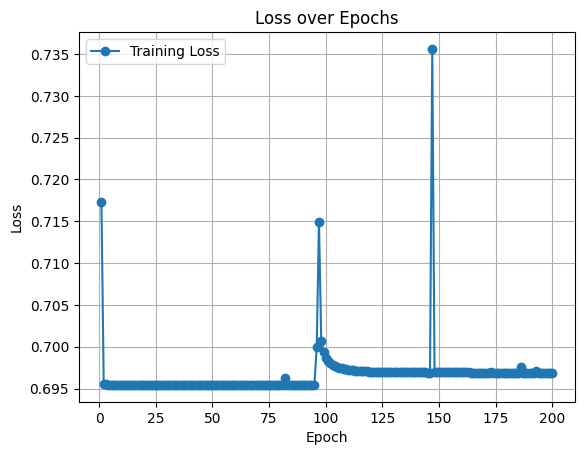

Proportion of Predicted 1's: 0.48
Proportion of Realized 1's: 0.49


In [178]:
losses = []
predictions_list = []
num_epochs = 200

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    epoch_predictions = []
    epoch_realized = []
    for X_batch, y_batch in trainloader:
        X_batch = X_batch.float().to(device)  # Ensure correct data type and device
        y_batch = y_batch.long().to(device)
        
        # X_batch = X_batch.permute(0, 2, 1) 
        
        optimizer.zero_grad()
        
        pred_y = model(X_batch)
        loss = criterion(pred_y, y_batch)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        
        # Detach predictions and convert to CPU for analysis (if using GPU)
        epoch_predictions.append(pred_y.detach().cpu().numpy())
        epoch_realized.append(y_batch.detach().cpu().numpy())
        
    # Calculate the average loss for the epoch
    average_loss = running_loss / len(trainloader)
    
    # Store the average loss for this epoch
    losses.append(average_loss)
    epoch_predictions = np.concatenate(epoch_predictions, axis=0)
    epoch_realized = np.concatenate(epoch_realized, axis=0)
    predictions_list.append(epoch_predictions)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")
    
# After training, plot the loss
plt.plot(range(1, num_epochs+1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

predicted_y = np.argmax(predictions_list[-1], axis=1)  # Shape: (1000,)
proportion_pred_over_0_5 = np.mean(predicted_y)
proportion_realised_ones = np.mean(np.array(epoch_realized) == 1)  # Ensure epoch_realized is an array

print(f"Proportion of Predicted 1's: {proportion_pred_over_0_5:.2f}\n"
    f"Proportion of Realized 1's: {proportion_realised_ones:.2f}")

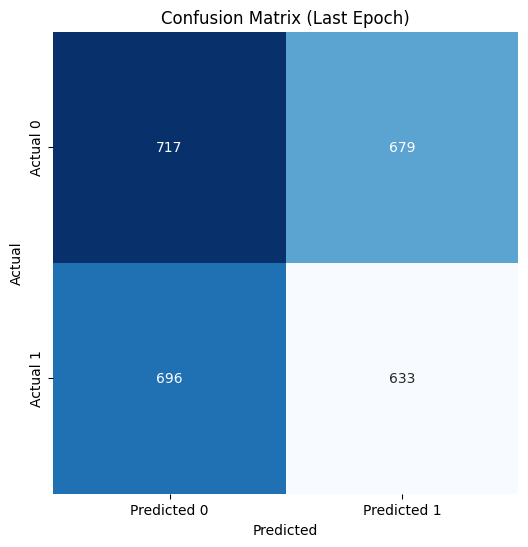

Accuracy: 0.50


In [179]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Generate the confusion matrix
conf_matrix = confusion_matrix(epoch_realized, predicted_y)

# Step 2: Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Last Epoch)')
plt.show()

TN, FP, FN, TP = conf_matrix.ravel()  # Unravel the confusion matrix
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")

In [180]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for X_batch, y_batch in dataloader:
    
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.long().to(device)
            
            
            pred_y = model(X_batch)
            
            loss = criterion(pred_y, y_batch)
            total_loss += loss.item()
            
            all_predictions.append(pred_y.detach().cpu().numpy())
            all_targets.append(y_batch.detach().cpu().numpy())
    
    # Calculate average loss
    average_loss = total_loss / len(dataloader)
    
    # Concatenate all predictions and targets
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    return average_loss, all_predictions, all_targets


In [181]:
test_loss, test_predictions, test_targets = evaluate_model(model, testloader, criterion, device)

from sklearn.metrics import accuracy_score

# If the model output is for a classification task (e.g., with softmax output)
predicted_classes = np.argmax(test_predictions, axis=1)  # Assuming softmax is used and you want class labels
accuracy = accuracy_score(test_targets, predicted_classes)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Test Loss: 0.7091
Test Accuracy: 0.4713
